# Imports

In [ ]:
import os
import requests
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mno
import matplotlib.pyplot as plt
import warnings

import torch

from sklearn import linear_model

from transformers import AutoTokenizer

%matplotlib inline
warnings.filterwarnings("ignore")

C:\Users\Bart\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [ ]:
# Specify your path to Capstone folder.

main_path = "/content/drive/MyDrive/Capstone_Diana/Capstone/"

In [ ]:
if "drive" in main_path:
    from google.colab import drive
    drive.mount("/content/drive")

In [ ]:
path = f"{main_path}Data/"
db_name = "MechanoPro-DB.xlsx"
db_path = os.path.join(path, db_name)
db_csv = pd.read_excel(db_path, "Main")
db_csv.head(4)

,Name (Click for details),PDB ID,SCOP annotation,Highest unfolding forces/ Clamp forces [pN],Standard Deviation of force [pN],Velocity [nm/s],Loading Rate [pN/s],Xu [nm],ΔG [kBT],Contour Length [nm],...,Authors,Pulling Reference,Unfolding Annotation,Unfolding Pathway,Mechanical Clamp,Unfolding Rate at Clamp Force [s-¹],F05 [pN],Uniprot,Sequence,Pulling Coordinates
0,(GB1)8 Suggest,1Q10,Alpha and beta proteins (a+b),111,NaN,50.0,NaN,0.17,NaN,18.0,...,"Byeon, I.J., Louis, J.M., Gronenborn, A.M.","Jiacheng Zuo , Hongbin Li - 2023",NaN,NaN,NaN,NaN,NaN,NaN,MQYKVILNGKTLKGETTTEAVDAATAEKVVKQFFNDNGVDGEWTYD...,NaN
1,(I27*)5 Suggest,1TIT,All beta proteins,144,NaN,77.0,NaN,0.29,NaN,NaN,...,"Improta, S., Politou, A.S., Pastore, A.","David J. Brockwell, Godfrey S. Beddard, Emanue...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(NuG2)4 Suggest,1MI0,Alpha and beta proteins (a/b),14,NaN,2.0,NaN,0.40,NaN,NaN,...,"Huizinga, E.G., Tsuji, S., Romijn, R.A.P., Sch...","Peiyun Li , Hongbin Li - 2024",NaN,NaN,NaN,NaN,NaN,NaN,HHHAMDTYKLVIVLNGTTFTYTTEAVDAATAEKVFKQYANDNGVDG...,NaN
3,(NuG2)4 Suggest,1MI0,Alpha and beta proteins (a/b),8,NaN,50.0,1.0,0.46,NaN,NaN,...,"Huizinga, E.G., Tsuji, S., Romijn, R.A.P., Sch...","Peiyun Li , Hongbin Li - 2024",NaN,NaN,NaN,NaN,NaN,NaN,HHHAMDTYKLVIVLNGTTFTYTTEAVDAATAEKVFKQYANDNGVDG...,NaN


In [ ]:
db_csv.isna().sum()

Name (Click for details)                          0
PDB ID                                           15
SCOP annotation                                   5
 Highest unfolding forces/ Clamp forces [pN]      0
Standard Deviation of force [pN]                219
Velocity [nm/s]                                   0
Loading Rate [pN/s]                             209
 Xu [nm]                                        143
 ΔG [kBT]                                       218
 Contour Length [nm]                            109
 Koff [s-¹]                                     164
 Temperature (°C )                              252
 Experimental Conditions                         50
 Total Length (AA)                              211
 Domain Coords                                  206
 3D Structure (click on the protein)            293
Organism                                         17
Mutations                                        15
Classification                                    5
Technique   

In [ ]:
# Removing all data entries obtained from Simulations.

db_csv = db_csv[~db_csv["Technique"].isin(["all atom SMD simulation", "Monte Carlo Simulations", "all atom SMD simulations",
                                           "Coarse-grained MD simulations"])]

In [ ]:
db_csv.columns = db_csv.columns.str.strip()

In [ ]:
# Simple preprocessing of column names.
# Dropping unnecessary columns from further analysis.

db_csv.columns = db_csv.columns.str.strip()
db_csv.rename(columns={"Name (Click for details)": "Name"}, inplace=True)
drop_cols = ["Released", "Authors", "Pulling Reference", "DOI Structure", "3D Structure (click on the protein)",
             "Mechanical Clamp", "F05 [pN]", "Temperature (°C )", "Mutations", "Domain Coords", "Loading Rate [pN/s]",
             "Unfolding Annotation"]
db_csv.drop(columns=drop_cols, axis=1,inplace=True)

In [ ]:
# Subsetting the dataset to get only entries with known sequences (as primary target is on sequence analysis)

db_csv_temp = db_csv.dropna(subset=["Sequence"])
len(db_csv_temp)

153

In [ ]:
# Checking that we do not have cases when Unfolding Pathway with contour lentghs is specified, but Contour Length is not

filtered_db_check = db_csv_temp[db_csv_temp["Unfolding Pathway"].notna() & db_csv_temp[["Contour Length [nm]"]].isna().any(axis=1)]
filtered_db_check

,Name,PDB ID,SCOP annotation,Highest unfolding forces/ Clamp forces [pN],Standard Deviation of force [pN],Velocity [nm/s],Xu [nm],ΔG [kBT],Contour Length [nm],Koff [s-¹],...,Total Length (AA),Organism,Classification,Technique,Pulling Mode,Unfolding Pathway,Unfolding Rate at Clamp Force [s-¹],Uniprot,Sequence,Pulling Coordinates


In [ ]:
# Dropping data entries which do not contain at least one original target variable.

db_csv_temp = db_csv_temp[db_csv_temp[["Koff [s-¹]", "Xu [nm]", "ΔG [kBT]"]].notna().any(axis=1)]
len(db_csv_temp)

127

In [ ]:
# Checking data quantity.

db_csv_temp.isna().sum()

Name                                             0
PDB ID                                           8
SCOP annotation                                  0
Highest unfolding forces/ Clamp forces [pN]      0
Standard Deviation of force [pN]                86
Velocity [nm/s]                                  0
Xu [nm]                                         30
ΔG [kBT]                                        94
Contour Length [nm]                             54
Koff [s-¹]                                      35
Experimental Conditions                          9
Total Length (AA)                               81
Organism                                         9
Classification                                   0
Technique                                        0
Pulling Mode                                     0
Unfolding Pathway                               83
Unfolding Rate at Clamp Force [s-¹]            127
Uniprot                                        127
Sequence                       

In [ ]:
# Removing word "Suggest" from the name (for ease of use).

db_csv_temp.loc[:, "Name"] = db_csv_temp["Name"].str.replace("Suggest", "")

In [ ]:
# Filling Total length column from Sequence column.

db_csv_temp["Total Length (AA)"] = db_csv_temp["Sequence"].apply(len)

In [ ]:
# Koff and Unfolding rate are the same in the scope of this project, making it necessary to merge them.

print(len(db_csv_temp[ db_csv_temp["Koff [s-¹]"].notna() & db_csv_temp["Unfolding Rate at Clamp Force [s-¹]"].notna()]))
# checked that either one or another exist.

db_csv_temp["Koff [s-¹]"] = db_csv_temp["Koff [s-¹]"].combine_first(db_csv_temp["Unfolding Rate at Clamp Force [s-¹]"])
db_csv_temp.drop(columns=["Unfolding Rate at Clamp Force [s-¹]"], inplace=True)

0


In [ ]:
# By looking at general divisions of existing contour lengths from database by their lengths, generally understood that the length of one
# aminoacid is 0.35 (although mainstream one is 0.4).
# Filling Contour Length for data entries.

db_csv_temp["Contour Length [nm]"] = db_csv_temp["Contour Length [nm]"].fillna(db_csv_temp["Total Length (AA)"] * 0.35)

In [ ]:
# Filling in default values of N and C terminus (start and end amino acids) for Pulling coordinates, if not specified customly.

db_csv_temp["Pulling Coordinates"] = db_csv_temp["Pulling Coordinates"].fillna(db_csv_temp.apply(lambda row: (1, row["Total Length (AA)"]), axis=1))
db_csv_temp["Pulling Coordinates"] = db_csv_temp["Pulling Coordinates"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
db_csv_temp["Pulling Coordinates"].unique()

array([(1, 56), (1, 61), (1, 57), (1, 271), (1, 98), (1, 104), (1, 59),
       (1, 106), (1, 227), (1, 280), (1, 208), (1, 201), (1, 105),
       (1, 240), (1, 288), (1, 102), (1, 83), (1, 53), (1, 23), (1, 206),
       (1, 100), (1, 99), (1, 80), (1, 445), (1, 116), (1, 211),
       (132, 212), (117, 182), (182, 212), (3, 132), (1, 90), (1, 89),
       (1, 91), (1, 92), (1, 570), (80, 41), (80, 1), (48, 76), (1, 76),
       (1, 196), (1, 488), (1, 159), (1, 67), (1, 155), (1, 85), (1, 143),
       (1, 138), (1, 321), (1, 109), (1, 172), (1, 110), (1, 383),
       (1, 162), (1, 129), (1, 178), (1, 230)], dtype=object)

In [ ]:
# Extracting Pulling Start and End values for the ease of use in models.

db_csv_temp[["Pulling Start", "Pulling End"]] = pd.DataFrame(db_csv_temp["Pulling Coordinates"].tolist(), index=db_csv_temp.index)
db_csv_temp.drop("Pulling Coordinates", axis=1, inplace=True)

# Old Way of Retrieving Protein Sequences (do not use, just showing)

In [ ]:
text_columns = ['Name','SCOP annotation','Experimental Conditions','Organism','Classification',
                'Technique','Pulling Mode','Unfolding Pathway','PDB ID','Uniprot']
db_csv[text_columns] = db_csv[text_columns].fillna("<UNK>")

In [ ]:
# Querying PDB and UniProt for extracting sequences

def fetch_protein_sequence(pdb_id, uniprot_id):
    if pd.notna(pdb_id):
      url = f"https://www.rcsb.org/fasta/entry/{pdb_id}/display"
    elif pd.notna(uniprot_id):
      url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    else:
      return "<UNK>"

    try:
      response = requests.get(url)
      if response.status_code == 200:
        sequence = "".join(response.text.split("\n")[1:])  # removing header
        return sequence
      else:
        return "<UNK>"
    except Exception as e:
      return "<UNK>"


In [ ]:
db_csv["Protein Sequence"] = db_csv.apply(lambda row: fetch_protein_sequence(row.get("PDB ID"), row.get("Uniprot")), axis=1)
db_csv['Protein_Sequence'] = db_csv['Protein Sequence'].str.replace(r'[>|].*', '', regex=True)
db_csv["Protein Sequence"].unique()

# Tokenizing

In [ ]:
# Specifying the columns and their data types for further usage.

text_columns = ["Name", "SCOP annotation", "Experimental Conditions", "Organism", "Classification",
                "Technique", "Pulling Mode", "Unfolding Pathway", "PDB_UniProt"]
integer_columns = ["Highest unfolding forces/ Clamp forces [pN]", "Standard Deviation of force [pN]", "Total Length (AA)", "Pulling Start", "Pulling End"]
float_columns = ["Velocity [nm/s]", "Xu [nm]", "ΔG [kBT]", "Contour Length [nm]", "Koff [s-¹]"]
numeric_columns = [*integer_columns, *float_columns]

## Tokenize Unfolding Pathway

In [ ]:
# Artificially filling Unfolding Pathway in case of smaller proteins (threshold of 110 is set, observed from data), having typically one unfolding.
threshold = 110

def fill_unfolding_pathway_based_on_sequence(row):
    if len(row["Sequence"]) < threshold:
        if pd.isna(row["Unfolding Pathway"]):
            rounded_contour_length = round(row["Contour Length [nm]"], 1)
            return f"N_U[{rounded_contour_length}]"
    return row["Unfolding Pathway"]

In [ ]:
db_csv_temp["Unfolding Pathway"] = db_csv_temp.apply(fill_unfolding_pathway_based_on_sequence, axis=1)

In [ ]:
db_csv_temp["Unfolding Pathway"].unique()

array(['N_U[18.0]', 'N_U[21.3]', 'N_U[19.9]', 'N_I[20]_U[28]', 'N_U[31]',
       'N_U[34.0]', 'N_U[20.6]', 'N_U[28.8]', 'N_U[33.2]', 'N_U[19.6]',
       nan, 'N_U[41]', 'N_U[39.0]', 'N_I[18]_I[26]_U[40]', 'N_U[38]',
       'N_U[6.4]', 'N_U[15.8]', 'N_U[24.5]', 'N_U[33.7]', 'N_U[26.0]',
       'N_U[18.5]', 'N_U[8.0]', 'N_I[15]_U[16]', 'N_U[30]', 'N_U[28.0]',
       'N_I[3.2]_I[6.78]_U[69.85]', 'N_I[39.3]_U[72.08]', 'N_U[31.5]',
       'N_U[27.3]', 'N_U[28.7]', 'N_U[31.1]', 'N_U[31.8]', 'N_U[32.2]',
       'N_U[31.9]', 'N_I[10.9]_U[24.2]', 'N_U[24.2]', 'N_U[7]', 'N_U[24]',
       'N_U[42]', 'N_U[34.3]', 'N_U[16.8]', 'N_U[18.8]', 'N_U[29.7]',
       'N_U[13]', 'N_U[29.0]', 'N_U[48.5]', 'N_U[48.6]', 'N_U[49.3]',
       'N_U[36]', 'N_U[12.0]', 'N_U[37.9]', 'N_U[33.0]', 'N_U[31.3]',
       'N_U[24.0]', 'N_I[10]_U[34]', 'N_I[10]_I[30]_I[50]_U[70]'],
      dtype=object)

In [ ]:
# Merging PDB and UniProt IDs as only one or another is given.

db_csv_temp["PDB_UniProt"] = db_csv_temp["PDB ID"].fillna('') + db_csv_temp["Uniprot"].fillna('')
db_csv_temp.drop(columns=["PDB ID", "Uniprot"], inplace=True)

In [ ]:
# Filling empty values for categorical columns by <UNK> token, recognized by models during tokenization.

db_csv_temp.loc[:, text_columns] = db_csv_temp[text_columns].fillna("<UNK>")

In [ ]:
# Extracting subsequences for proteins, based on their Unfolding Pathway --> One sequence is divided into multiple.

def extract_subsequences(pathway: str, sequence: str, total_aa: int, contour_length: float):
    pattern = r"\[([\d\.]+)\]"
    points_nm = [float(p) for p in re.findall(pattern, pathway)]
    print(f"Old positions: {points_nm}")
    final_contour_length = min(points_nm[-1], contour_length)
    print(f"Final contour length to use: {final_contour_length}")
    points_nm[-1] = final_contour_length
    print(f"New positions: {points_nm}")
    nm_per_aa = final_contour_length / total_aa
    print(f"Length of one AA: {nm_per_aa}")
    points_aa = [round(p / nm_per_aa) for p in points_nm]
    print(f"Points in amino acids: {points_aa}")
    if points_aa[-1] > final_contour_length:
        points_aa[-1] = int(min(points_aa[-1], round(final_contour_length / nm_per_aa)))

    subsequences = []
    previous_idx = 0

    for idx, point in enumerate(points_aa):
        subseq = sequence[previous_idx:point]
        subsequences.append(subseq)
        previous_idx = point

    return subsequences

def apply_subsequence_extraction(df):
    domain_seqs = []
    for _, row in df.iterrows():
        try:
            subseqs = extract_subsequences(
                pathway=row["Unfolding Pathway"],
                sequence=row["Sequence"],
                total_aa=row["Total Length (AA)"],
                contour_length=row["Contour Length [nm]"]
            )
        except Exception:
            subseqs = []
        domain_seqs.append(subseqs)
    df["domain_subsequences"] = domain_seqs
    return df

In [ ]:
db_csv_temp = apply_subsequence_extraction(db_csv_temp)

Old positions: [18.0]
Final contour length to use: 18.0
New positions: [18.0]
Length of one AA: 0.32142857142857145
Points in amino acids: [56]
Old positions: [21.3]
Final contour length to use: 21.3
New positions: [21.3]
Length of one AA: 0.34918032786885245
Points in amino acids: [61]
Old positions: [21.3]
Final contour length to use: 21.3
New positions: [21.3]
Length of one AA: 0.34918032786885245
Points in amino acids: [61]
Old positions: [19.9]
Final contour length to use: 19.9
New positions: [19.9]
Length of one AA: 0.34912280701754383
Points in amino acids: [57]
Old positions: [20.0, 28.0]
Final contour length to use: 28.0
New positions: [20.0, 28.0]
Length of one AA: 0.1033210332103321
Points in amino acids: [194, 271]
Old positions: [31.0]
Final contour length to use: 31.0
New positions: [31.0]
Length of one AA: 0.3163265306122449
Points in amino acids: [98]
Old positions: [34.0]
Final contour length to use: 34.0
New positions: [34.0]
Length of one AA: 0.3269230769230769
Point

In [ ]:
# Defining a number of subsequences, which are furtherly inputted for the models to predict that number of prediction sets, not one
# However, as a result, this method was not implemented due to necessity for inputting structural data of proteins first.

db_csv_temp["num_subsequences"] = db_csv_temp["domain_subsequences"].apply(len)

In [ ]:
db_csv_temp["domain_subsequences"] = db_csv_temp["domain_subsequences"].apply(
    lambda x: "<UNK>" if isinstance(x, list) and len(x) == 0 else x
    )

## Tokenize Text Columns

In [ ]:
# Creating a Joint text data column for the ease of usage and less memory and time consumption during model training.

for i in db_csv_temp.index:
    db_csv_temp.loc[i, "Joint_Text_Cols"] = db_csv_temp.loc[i, text_columns].str.cat(sep=" [SEP] ")

text_columns.extend(["Joint_Text_Cols"])

In [ ]:
# Defining models for tokenization of text columns.

protein_model_name = "Rostlab/prot_bert_bfd"
text_model_name = "allenai/scibert_scivocab_uncased"

protein_tokenizer = AutoTokenizer.from_pretrained(protein_model_name)
text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)

In [ ]:
# Defining max lengths of our sequences for padding.

protein_max_length = db_csv_temp["Sequence"].apply(len).max()
text_max_length = db_csv_temp[text_columns].apply(lambda row: row.apply(len).max(), axis=1).max() # for other text columns

In [ ]:
def tokenize_protein(text):
    """
    Tokenizes protein sequences using the protein tokenizer.
    """
    text = str(text)
    return protein_tokenizer(text, padding="max_length", truncation=True, max_length=protein_max_length, return_tensors=None)

def tokenize_text(text):
    """
    Tokenizes text columns using the text tokenizer.
    """
    text = str(text)
    return text_tokenizer(text, padding="max_length", truncation=True, max_length=text_max_length, return_tensors=None)

In [ ]:
# Tokenizing our categorical columns.

db_csv_temp[f"tokenized_Sequence"] = db_csv_temp["Sequence"].apply(tokenize_protein)
for col in text_columns:
    db_csv_temp[f"tokenized_{col}"] = db_csv_temp[col].apply(tokenize_text)

In [ ]:
# Applying unique tokenization for domain subsequences, using the same protein_tokenizer

max_domain_length = max(db_csv_temp["domain_subsequences"].apply(lambda lst: max(len(s) for s in lst) if lst else 0))
db_csv_temp["tokenized_domain_subsequences"] = None

for _, row in db_csv_temp.iterrows():
    subsequences = row["domain_subsequences"]
    tokenized_subsequences = []
    for subseq in subsequences:
        tokenized_subseq = protein_tokenizer(subseq, padding=True, truncation=True, max_length=max_domain_length, return_tensors="pt")
        tokenized_subsequences.append(tokenized_subseq)
    db_csv_temp.at[_, "tokenized_domain_subsequences"] = tokenized_subsequences


# Process Numeric Features (by regression imputings)

code for this part was taken from this GitHub page:

https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression


In [ ]:
db_csv_copy = db_csv_temp.copy()

<Axes: >

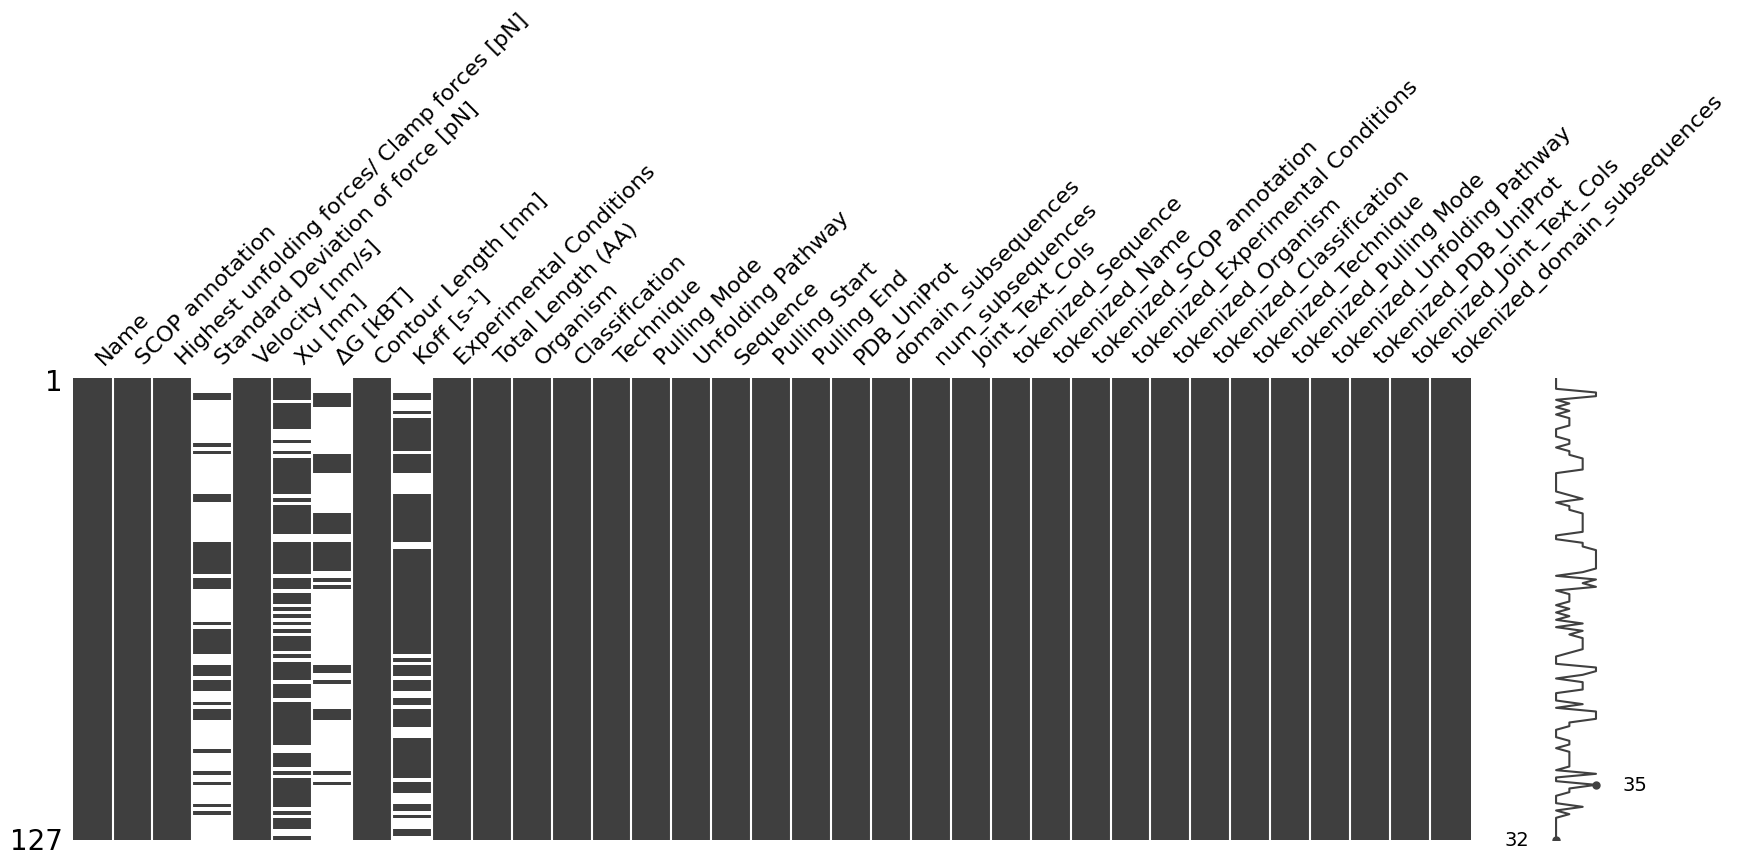

In [ ]:
# Checking which numeric columns contain missing values and should be processed in this section.

mno.matrix(db_csv_temp, figsize = (20, 6))

In [ ]:
# Aggregating tokenized text columns to use them for regression imputings.

def aggregate_tokenized_features(df, columns):
    for col in columns:
        df[col + "_mean"] = df[col].apply(
            lambda x: np.mean(x[-1].input_ids.numpy()) if isinstance(x, list) and len(x) > 0 and hasattr(x[-1], "input_ids") else 0
                            )
        df[col + "_sum"] = df[col].apply(
            lambda x: np.sum(x[-1].input_ids.numpy()) if isinstance(x, list) and len(x) > 0 and hasattr(x[-1], "input_ids") else 0
                            )
        df[col + "_max"] = df[col].apply(
            lambda x: np.max(x[-1].input_ids.numpy()) if isinstance(x, list) and len(x) > 0 and hasattr(x[-1], "input_ids") else 0
                            )
    return df

In [ ]:
# Applying feature extraction and aggregation.

tokenized_columns = [col for col in db_csv_copy.columns if col.startswith("tokenized_")]
print(tokenized_columns)
db_csv_copy = aggregate_tokenized_features(db_csv_copy, tokenized_columns)

['tokenized_Sequence', 'tokenized_Name', 'tokenized_SCOP annotation', 'tokenized_Experimental Conditions', 'tokenized_Organism', 'tokenized_Classification', 'tokenized_Technique', 'tokenized_Pulling Mode', 'tokenized_Unfolding Pathway', 'tokenized_PDB_UniProt', 'tokenized_Joint_Text_Cols', 'tokenized_domain_subsequences']


In [ ]:
# Specifying missing columns, which should be filled during the analysis.

missing_columns = ["Standard Deviation of force [pN]", "Xu [nm]", "ΔG [kBT]", "Koff [s-¹]"]

In [ ]:
def random_imputation(df, feature):
    """
    Randomly imputes missing values by sampling from observed values.
    """
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + "_imp"] = np.random.choice(observed_values, number_missing, replace=True)
    return df

In [ ]:
# First, randomly imputing values instead of missing values.

for feature in missing_columns:
    db_csv_copy[feature + "_imp"] = db_csv_copy[feature]
    db_csv_copy = random_imputation(db_csv_copy, feature)

In [ ]:
val_to_remove = [col.replace("tokenized_", "") for col in db_csv_temp.columns if col.startswith("tokenized_")]
tokenized_val_to_remove = [col for col in db_csv_temp.columns if col.startswith("tokenized_")]
values_to_remove = val_to_remove + tokenized_val_to_remove

In [ ]:
# using Deterministic Regression (better approach is to use maximum likelihood imputation) for correctly filling in the approximate values.

deter_data = pd.DataFrame(columns=["Det" + name for name in missing_columns])

for feature in missing_columns:
    deter_data["Det" + feature] = db_csv_copy[feature + "_imp"]
    token_feature_columns = [col for col in db_csv_copy.columns if col.endswith(("_mean", "_sum", "_max"))]
    old_parameters = list(set(db_csv_copy.columns) - set(missing_columns) - {feature + "_imp"} | set(token_feature_columns))
    parameters = [x for x in old_parameters if x not in values_to_remove]
    print(parameters)
    model = linear_model.LinearRegression()
    model.fit(X=db_csv_copy[parameters], y=db_csv_copy[feature + "_imp"])
    deter_data.loc[db_csv_copy[feature].isnull(), "Det" + feature] = model.predict(db_csv_copy[parameters])[db_csv_copy[feature].isnull()]


['Pulling Start', 'tokenized_Unfolding Pathway_max', 'Velocity [nm/s]', 'Pulling End', 'ΔG [kBT]_imp', 'tokenized_SCOP annotation_max', 'tokenized_Experimental Conditions_mean', 'Contour Length [nm]', 'tokenized_Classification_mean', 'tokenized_Classification_sum', 'Highest unfolding forces/ Clamp forces [pN]', 'tokenized_Joint_Text_Cols_sum', 'tokenized_Sequence_max', 'tokenized_Name_sum', 'tokenized_Classification_max', 'tokenized_Technique_max', 'tokenized_Technique_mean', 'tokenized_PDB_UniProt_sum', 'tokenized_Name_max', 'tokenized_Experimental Conditions_sum', 'tokenized_Unfolding Pathway_mean', 'Total Length (AA)', 'tokenized_Sequence_sum', 'tokenized_PDB_UniProt_mean', 'tokenized_Technique_sum', 'tokenized_Experimental Conditions_max', 'tokenized_Pulling Mode_mean', 'tokenized_domain_subsequences_mean', 'Xu [nm]_imp', 'tokenized_Unfolding Pathway_sum', 'tokenized_Pulling Mode_sum', 'tokenized_Organism_sum', 'tokenized_Name_mean', 'tokenized_SCOP annotation_sum', 'tokenized_Orga

In [ ]:
# Chech that none of the columns contain Nan values.

nan_columns = db_csv_copy[parameters].isnull().any()
nan_columns = nan_columns[nan_columns].index.tolist()

print("Columns containing NaN values:", nan_columns)

Columns containing NaN values: []


<Axes: >

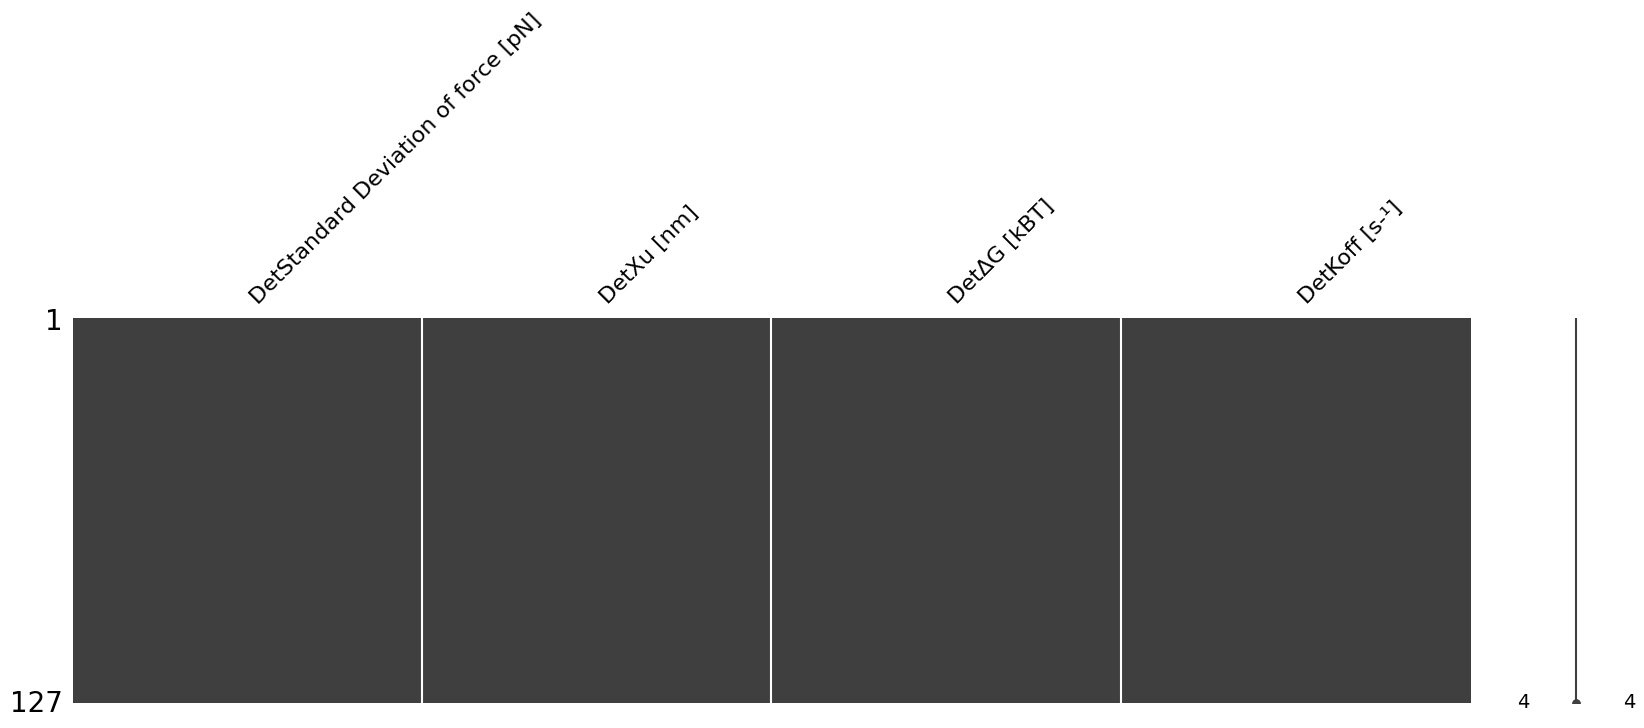

In [ ]:
# Visualize the columns with missing data after fill and make sure that no missing values are left.

mno.matrix(deter_data, figsize = (20,5))

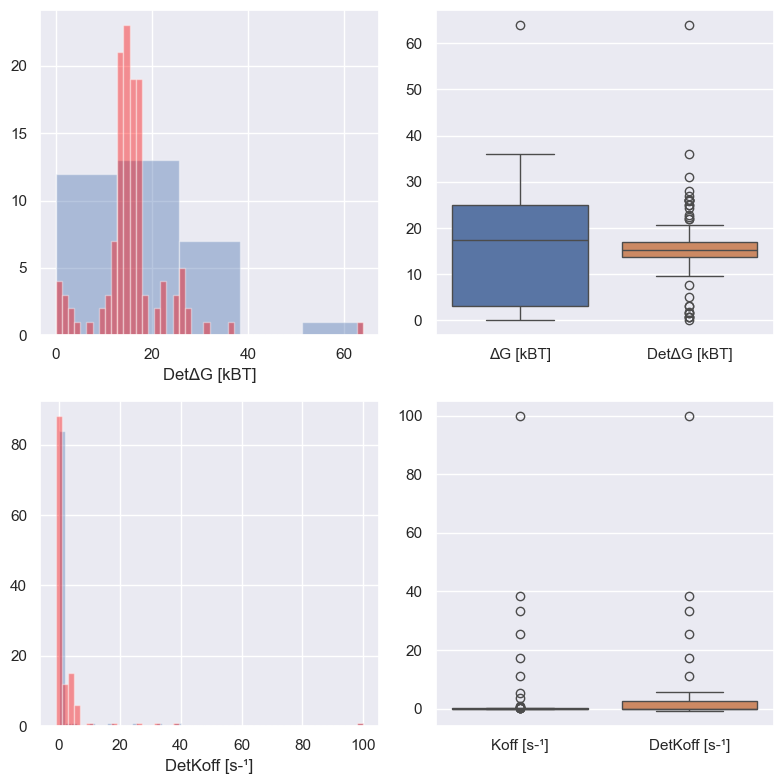

In [ ]:
# Checking variability of data.

sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["ΔG [kBT]", "Koff [s-¹]"]):
    sns.distplot(db_csv_copy[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = "red")

    sns.boxplot(data = pd.concat([db_csv_copy[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])

plt.tight_layout()

In [ ]:
# Adding uncertainty back to data to increase the variability.

random_data = pd.DataFrame(columns=["Ran" + name for name in missing_columns])

for feature in missing_columns:
    random_data["Ran" + feature] = db_csv_copy[feature + "_imp"]
    token_feature_columns = [col for col in db_csv_copy.columns if col.endswith(("_mean", "_sum", "_max"))]
    old_parameters = list(set(db_csv_copy.columns) - set(missing_columns) - {feature + "_imp"} | set(token_feature_columns))
    parameters = [x for x in old_parameters if x not in values_to_remove]
    print(parameters)
    model = linear_model.LinearRegression()
    model.fit(X=db_csv_copy[parameters], y=db_csv_copy[feature + "_imp"])
    predict = model.predict(db_csv_copy[parameters])
    std_error = (predict[db_csv_copy[feature].notnull()] - db_csv_copy.loc[db_csv_copy[feature].notnull(), feature + '_imp']).std()
    random_predict = np.random.normal(size=db_csv_copy[feature].shape[0], loc=predict, scale=std_error)
    random_data.loc[(db_csv_copy[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(db_csv_copy[feature].isnull()) & (random_predict > 0)]


['Pulling Start', 'tokenized_Unfolding Pathway_max', 'Velocity [nm/s]', 'Pulling End', 'ΔG [kBT]_imp', 'tokenized_SCOP annotation_max', 'tokenized_Experimental Conditions_mean', 'Contour Length [nm]', 'tokenized_Classification_mean', 'tokenized_Classification_sum', 'Highest unfolding forces/ Clamp forces [pN]', 'tokenized_Joint_Text_Cols_sum', 'tokenized_Sequence_max', 'tokenized_Name_sum', 'tokenized_Classification_max', 'tokenized_Technique_max', 'tokenized_Technique_mean', 'tokenized_PDB_UniProt_sum', 'tokenized_Name_max', 'tokenized_Experimental Conditions_sum', 'tokenized_Unfolding Pathway_mean', 'Total Length (AA)', 'tokenized_Sequence_sum', 'tokenized_PDB_UniProt_mean', 'tokenized_Technique_sum', 'tokenized_Experimental Conditions_max', 'tokenized_Pulling Mode_mean', 'tokenized_domain_subsequences_mean', 'Xu [nm]_imp', 'tokenized_Unfolding Pathway_sum', 'tokenized_Pulling Mode_sum', 'tokenized_Organism_sum', 'tokenized_Name_mean', 'tokenized_SCOP annotation_sum', 'tokenized_Orga

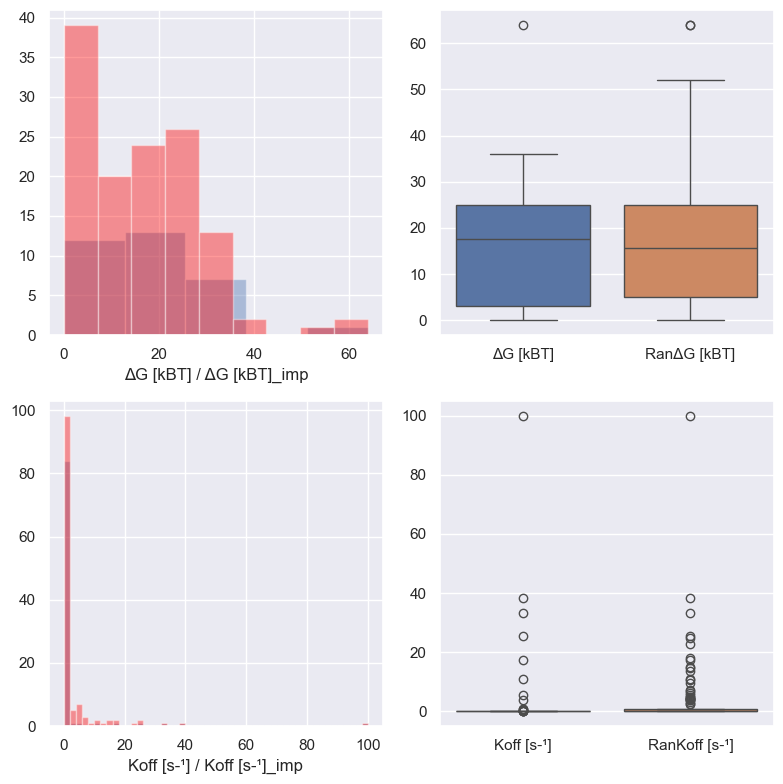

In [ ]:
# Check the variability once again to make sure actual parameters variability is retained.

sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["ΔG [kBT]", "Koff [s-¹]"]):
    sns.distplot(db_csv_copy[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = "red")
    axes[index, 0].set(xlabel = variable + " / " + variable + "_imp")

    sns.boxplot(data = pd.concat([db_csv_copy[variable], random_data["Ran" + variable]], axis = 1),
                ax = axes[index, 1])

    plt.tight_layout()

In [ ]:
# Removing original missing columns and rename new filed columns into original names.

db_csv_temp = db_csv_temp.join(random_data)
db_csv_temp.drop(columns=missing_columns, inplace=True)
db_csv_temp.rename(columns={col: col.replace("Ran", "") for col in random_data.columns}, inplace=True)

In [ ]:
# Convert targets columns into a separate column 'targets', containing tensors of length 3 (for each target variable)

target_columns = ["ΔG [kBT]", "Xu [nm]", "Koff [s-¹]"]
db_csv_temp.loc[:, "targets"] = db_csv_temp[target_columns].apply(lambda row: torch.tensor(row.values, dtype=torch.float32), axis=1)

In [ ]:
# Convert numeric columns into a separate column 'numeric_embeddings', containing tensors of length 7 (for each numeric feature)

numeric_columns_upd = [x for x in numeric_columns if x not in target_columns]
db_csv_temp.loc[:, "numeric_embeddings"] = db_csv_temp[numeric_columns_upd].apply(lambda row: torch.tensor(row.values, dtype=torch.float), axis=1)

# Saving

Format for saving: **numerical.tokenization_protein.tokenization_text.tokenization_length**

Example: tokenized_dataset_0_protbert_scibert_98


In [ ]:
df = db_csv_temp.copy()

In [ ]:
# Specifying approaches for tokenizations and imputings.

numeric_method = "regression_imputings" # handling nan values
sequence_method = "protbert"
text_method = "scibert"
database = "mechano"

In [ ]:
dataset_name = f"tokenized_dataset_{numeric_method}_{sequence_method}_{text_method}_{len(db_csv_temp)}_{database}"
pickle_path = f"{main_path}Tokenized_results/{dataset_name}.pkl"

In [ ]:
df.to_pickle(pickle_path)
print(f"Dataset is successfully saved as pickle: {pickle_path}")

✅ Dataset successfully saved as Pickle: /content/drive/MyDrive/Capstone/Tokenized_results/tokenized_dataset_regression_imputings_protbert_scibert_127.pkl


***

# End of Preprocessing part